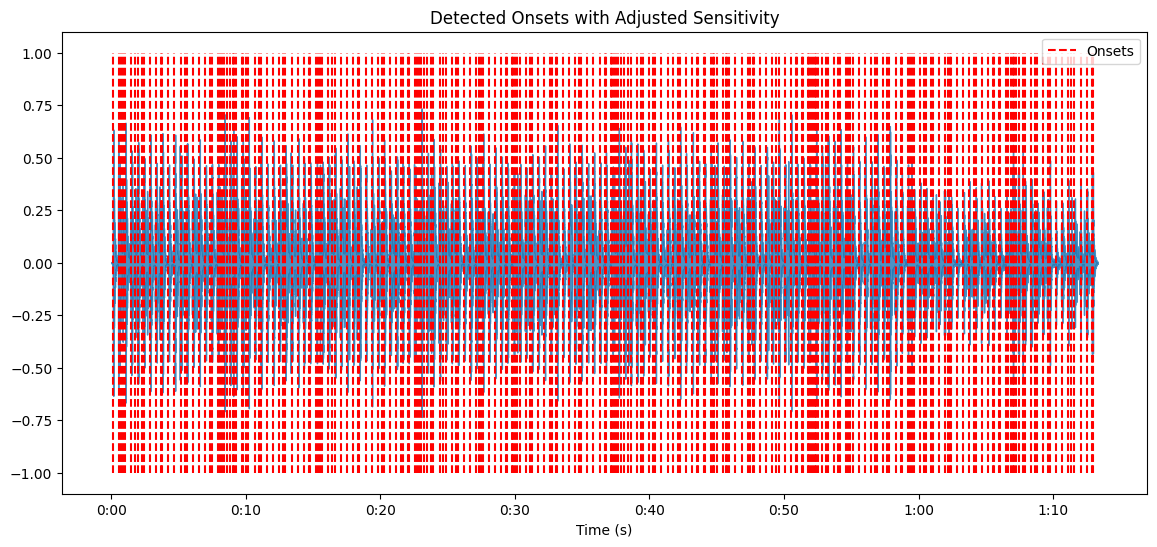

Onset times (in seconds): [ 0.1015873   0.55727891  0.70240363  0.83882086  1.01297052  1.47446712
  1.77342404  1.9475737   2.301678    2.38875283  2.85605442  3.31464853
  3.69487528  3.77614512  4.22022676  4.67882086  5.13741497  5.44217687
  5.61052154  6.06621315  6.51319728  6.98340136  7.36072562  7.44199546
  7.89478458  8.0370068   8.190839    8.34176871  8.57396825  8.80036281
  9.04997732  9.10512472  9.27637188  9.7262585   9.79882086 10.02231293
 10.18195011 10.6492517  10.93950113 11.1078458  11.56353741 12.00761905
 12.46621315 12.77387755 12.93931973 13.39210884 13.84780045 14.29768707
 14.6924263  14.77079365 15.21487528 15.36870748 15.50222222 15.67637188
 16.12335601 16.4339229  16.60517007 17.05505669 17.51945578 17.96643991
 18.35827664 18.43954649 18.8923356  19.34512472 19.80952381 20.10557823
 20.2739229  20.72671202 21.17369615 21.51909297 21.64390023 22.02702948
 22.10249433 22.55818594 22.70331066 22.85424036 23.00807256 23.23736961
 23.4492517  23.76852608 

250

In [29]:
# Import necessary libraries
import librosa
import librosa.display
import matplotlib.pyplot as plt
import requests

# Download the file to a local path
audio_url = 'https://github.com/egorpol/beat_it/raw/refs/heads/main/examples/vision_spectral_mono.aif'
local_audio_path = 'vision_spectral_mono.aif'

# Download the file
response = requests.get(audio_url)
with open(local_audio_path, 'wb') as f:
    f.write(response.content)

# Define the hop length globally
hop_length = 64

# Load the audio file
y, sr = librosa.load(local_audio_path)

# Onset detection with custom sensitivity
onset_frames = librosa.onset.onset_detect(y=y, sr=sr,
                                          delta=0.1,       # Lower value for more sensitivity (default is 0.07)
                                          backtrack=True,   # Enable backtracking to improve onset timing
                                          pre_max=1,       # Increase to be less sensitive to nearby peaks
                                          post_max=1,      # Increase for less sensitivity to nearby peaks
                                          hop_length=hop_length)  # Use global hop length

# Convert onset frames to times
onset_times = librosa.frames_to_time(onset_frames, sr=sr, hop_length=hop_length)  # Use global hop length

# Plot the waveform and onset times
plt.figure(figsize=(14, 6))
librosa.display.waveshow(y, sr=sr, alpha=0.8)
plt.vlines(onset_times, ymin=-1, ymax=1, color='r', linestyle='--', label='Onsets')
plt.title('Detected Onsets with Adjusted Sensitivity')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

# Print the onset times
print('Onset times (in seconds):', onset_times)

len(onset_times)


In [25]:
import pandas as pd

# Create a DataFrame
df_seq = pd.DataFrame({"onset_times": seq1})


# Define the file path
file_path = 'vision_onsets_librosa_unfiltered.csv'

# Save the DataFrame to a CSV file
df_seq.to_csv(file_path, index=False)

# Print the dynamic message
print(f"Sequence has been saved to '{file_path}'")

Sequence has been saved to 'vision_onsets_librosa_unfiltered.csv'


In [ ]:
import numpy as np

iois = np.diff(onset_times)


print(iois)


[0.35410431 0.09868481 0.14512472 0.13351474 0.17995465 0.22639456
 0.23219955 0.29605442 0.17414966 0.33088435 0.11029478 0.47020408
 0.4585941  0.23800454 0.14512472 0.08126984 0.44117914 0.4585941
 0.4585941  0.15092971 0.15092971 0.16834467 0.4585941  0.44698413
 0.37732426 0.09287982 0.37732426 0.08126984 0.34249433 0.11029478
 0.14512472 0.15092971 0.15092971 0.23219955 0.22639456 0.22058957
 0.2554195  0.45278912 0.06965986 0.22058957 0.16253968 0.46439909
 0.29024943 0.16834467 0.4585941  0.44117914 0.45278912 0.31927438
 0.16253968 0.44698413 0.3076644  0.15673469 0.44117914 0.40054422
 0.07546485 0.44698413 0.15673469 0.12770975 0.17995465 0.23219955
 0.21478458 0.3076644  0.16834467 0.45278912 0.23219955 0.23219955
 0.13931973 0.3076644  0.15092971 0.24380952 0.08126984 0.42376417
 0.48181406 0.46439909 0.13931973 0.15092971 0.16834467 0.37151927
 0.08707483 0.44698413 0.32507937 0.14512472 0.37732426 0.07546485
 0.35410431 0.1044898  0.13931973 0.15673469 0.15673469 0.22639

In [ ]:
import numpy as np

# Desired interval and tolerance
interval = 0.45    # Desired interval in seconds
tolerance = 0.1    # Tolerance in seconds

# Build a directed acyclic graph (DAG) where nodes are onset times
edges = {t: [] for t in onset_times}

# Construct edges between onset times that are approximately 'interval' apart
for i in range(len(onset_times)):
    for j in range(i + 1, len(onset_times)):
        delta_t = onset_times[j] - onset_times[i]
        if abs(delta_t - interval) <= tolerance:
            edges[onset_times[i]].append(onset_times[j])

# Function to find the longest path starting from a given node
def find_longest_path(node, edges, memo):
    if node in memo:
        return memo[node]
    max_length = 1
    max_path = [node]
    for neighbor in edges[node]:
        path = find_longest_path(neighbor, edges, memo)
        if 1 + len(path) > max_length:
            max_length = 1 + len(path)
            max_path = [node] + path
    memo[node] = max_path
    return max_path

# Find all longest sequences in the DAG
memo = {}
longest_length = 0
longest_paths = []

for node in onset_times:
    path = find_longest_path(node, edges, memo)
    if len(path) > longest_length:
        longest_length = len(path)
        longest_paths = [path]
    elif len(path) == longest_length:
        longest_paths.append(path)

# Output all sequences that have the longest length
for idx, path in enumerate(longest_paths):
    print(f"Sequence {idx + 1}:")
    print(np.array(path))


Sequence 1:
[ 0.1044898   0.55727891  1.01587302  1.47446712  1.9446712   2.38585034
  2.85605442  3.31464853  3.69777778  4.22022676  4.67882086  5.13741497
  5.60761905  6.06621315  6.51319728  6.89052154  7.36072562  7.89478458
  8.34176871  8.80036281  9.27637188  9.729161   10.18195011 10.64634921
 11.10494331 11.56353741 12.00471655 12.45750567 12.93931973 13.38630385
 13.85070295 14.29188209 14.6924263  15.21487528 15.67927438 16.1262585
 16.60226757 17.05505669 17.51945578 17.96643991 18.36117914 18.86621315
 19.34802721 19.8124263  20.27102041 20.64253968 21.17659864 21.64680272
 22.02412698 22.55818594 23.01097506 23.48117914 23.93396825 24.38675737
 24.84535147 25.29814059 25.76834467 26.22113379 26.66811791 27.138322
 27.60272109 28.04390023 28.50249433 28.96689342 29.35582766 29.88408163
 30.34848073 30.78385488 31.26566893 31.71845805 32.18285714 32.63564626
 33.01877551 33.52961451 33.99981859 34.47002268 34.92861678 35.39301587
 35.82839002 36.21732426 36.68172336 37.22

In [ ]:
# Automatically detect the number of sequences
num_sequences = len(longest_paths)

# Loop through all sequences and print them dynamically
for idx in range(num_sequences):
    sequence = longest_paths[idx]
    print(f"Sequence {idx + 1}:")
    print(np.array(sequence))

    # You can store each sequence in a variable dynamically if needed
    # e.g., if you want to store the first sequence:
    if idx == 0:
        seq1 = sequence
    elif idx == 1:
        seq2 = sequence
    elif idx == 2:
        seq3 = sequence


Sequence 1:
[ 0.1044898   0.55727891  1.01587302  1.47446712  1.9446712   2.27555556
  2.85605442  3.31464853  3.69777778  4.22022676  4.67882086  5.13741497
  5.60761905  6.06621315  6.51319728  6.98340136  7.36072562  7.89478458
  8.34176871  8.80036281  9.27637188  9.729161   10.18195011 10.64634921
 11.10494331 11.56353741 12.00471655 12.45750567 12.93931973 13.38630385
 13.85070295 14.29188209 14.6924263  15.21487528 15.67927438 16.1262585
 16.60226757 17.05505669 17.51945578 17.96643991 18.36117914 18.86621315
 19.34802721 19.8124263  20.27102041 20.72961451 21.17659864 21.501678
 22.02412698 22.55818594 23.01097506 23.48117914 23.93396825 24.38675737
 24.84535147 25.29814059 25.76834467 26.22113379 26.66811791 27.138322
 27.60272109 28.04390023 28.50249433 28.96689342 29.35582766 29.78539683
 30.34848073 30.78385488 31.26566893 31.71845805 32.18285714 32.63564626
 33.01877551 33.52961451 33.99981859 34.47002268 34.92861678 35.39301587
 35.82839002 36.30439909 36.68172336 37.1112

In [ ]:
import pandas as pd

# Create a DataFrame
df_seq = pd.DataFrame({"onset_times": seq1})


# Define the file path
file_path = 'vision_onsets_bdrum_filtered.csv'

# Save the DataFrame to a CSV file
df_seq.to_csv(file_path, index=False)

# Print the dynamic message
print(f"Sequence has been saved to '{file_path}'")

Sequence has been saved to 'vision_onsets_bdrum_filtered.csv'
